In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, figure, subplot, legend, xticks, yticks
from skimage.io import imread, imsave, imshow

import numpy as np

# monkey patch - faster fft
import numpy.fft
import pyfftw.interfaces.numpy_fft
numpy.fft = pyfftw.interfaces.numpy_fft

# register translation through phase correlation
from skimage.feature import register_translation, match_template
import imreg_dft as imreg

# check monkey patch
from skimage.feature.register_translation import np as rtnp
rtnp.fft, imreg.imreg.fft

(<module 'pyfftw.interfaces.numpy_fft' from '/Users/arve/.virtualenvs/3.4/lib/python3.4/site-packages/pyfftw/interfaces/numpy_fft.py'>,
 <module 'pyfftw.interfaces.numpy_fft' from '/Users/arve/.virtualenvs/3.4/lib/python3.4/site-packages/pyfftw/interfaces/numpy_fft.py'>)

In [16]:
from leicaexperiment import Experiment
e = Experiment('data/experiment--2015_04_29_16_35_42 - Copy')

rows = e.field_rows(0,0)
cols = e.field_columns(0,0)

img1 = imread(e.image(0,0,0,0))
img2 = imread(e.image(0,0,0,1))

# find translation with phase correlation

In [17]:
%%time
translations = []
row = 0
for col in cols:
    p = e.image(0, 0, row, col)
    next_p = e.image(0, 0, row, col+1)
    if not next_p:
        continue

    img1 = imread(p)
    img2 = imread(next_p)

    #only use half of images
    y,x = img1.shape
    img1 = img1[:,x//2:]
    img2 = img2[:,:x//2]
    
    #pos,err,phase_diff = register_translation(img1, img2, upsample_factor=10)
    pos,success = imreg.translation(img1, img2)
    translations.append((pos[0], pos[1], row, col))

# so that we can use slice notation
translations = np.array(translations)

CPU times: user 1.21 s, sys: 367 ms, total: 1.57 s
Wall time: 1.59 s


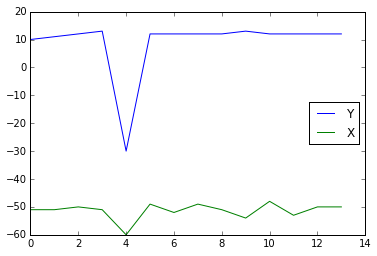

In [18]:
plot(translations[:,0:2])
legend(('Y', 'X'), loc='best');

In [19]:
np.median(translations[:,1]), np.std(translations[:,1])

(-51.0, 2.8437184624849121)

# removing outliers

In [20]:
def find_outliers(data, m=3):
    return abs(data - np.mean(data)) > m * np.std(data)


def cancel_outliers(data):
    outliers = find_outliers(data)
    while np.any(outliers):
        data[outliers] = np.median(data)
        outliers = find_outliers(data)
    # data changed in place, return anyhow
    return data

In [21]:
cancel_outliers(translations[:,1])

array([-51, -51, -50, -51, -51, -49, -52, -49, -51, -54, -48, -53, -50, -50])

In [22]:
np.std(translations[:,1]), np.mean(translations[:,1]), np.median(translations[:,1])

(1.5319721849662298, -50.714285714285715, -51.0)

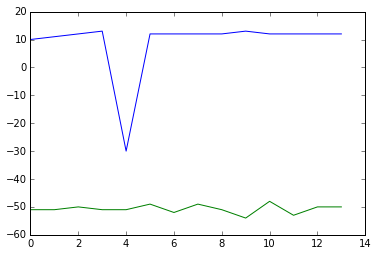

In [23]:
plot(translations[:,0:2]);

In [24]:
%run utils.ipynb

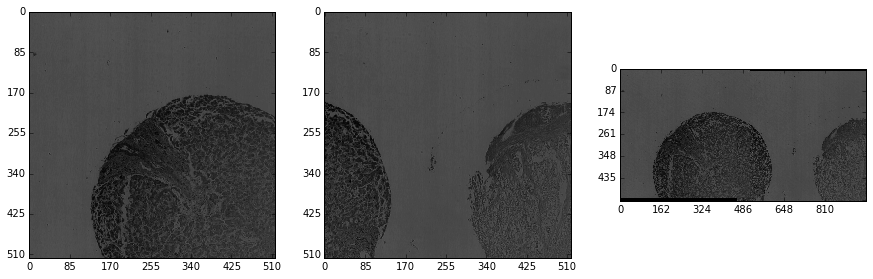

In [39]:
img1 = imread(e.image(0,0,0,0))
img2 = imread(e.image(0,0,0,1))

y_offset, x_offset = translations[0,0:2]
x_offset %= 512

merged = stitch(img1, img2, y_offset, x_offset)
side_by_side(img1, img2, merged)

In [41]:
y_offset, x_offset

(10, 461)

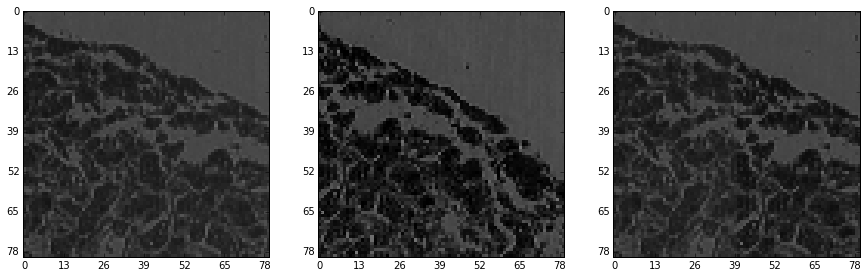

In [40]:
mask = np.index_exp[180:260, x_offset-40:x_offset+40]

side_by_side(img1[mask], img2[180:260, :80], merged[mask]);

# merge with variable offset

In [68]:
width = 512*len(cols) + int(translations[:,1].sum())
width

6978

In [69]:
merged = np.zeros((512, width), dtype=np.uint8)

In [73]:
merged[:,0:512] = imread(e.image(0,0,0,0))
for col in cols[1:]:
    p = e.image(0,0,0,col)
    offset = translations[col-1,1] // 2 # half of each image
    start = 512*col + int(sum(translations[:col-1,1]) + offset)
    end = start + 512 + offset
    merged[:,start:end] = imread(p)[:,-offset:]

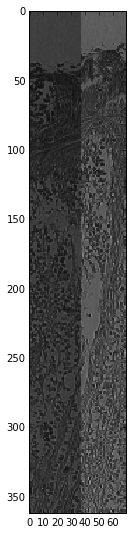

In [86]:
figure(figsize=(2,9))
imshow(merged[150:,910:980], cmap='gray');

In [63]:
io.imsave('merged_row.png', merged)

# all translations

In [65]:
translations = []
for row in rows:
    prev_p = None
    for col in cols:
        p = e.image(0, 0, col, row)
        if prev_p:
            img1 = io.imread(prev_p)
            img2 = io.imread(p)
            pos,err,ph = register_translation(img1, img2, upsample_factor=100)
            #pos = x_registration(img1, img2)
            translations.append((pos[0], pos[1], row, col))
        prev_p = p
translations = np.array(translations)

In [66]:
%matplotlib inline

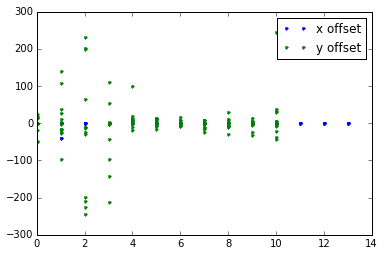

In [67]:
plt.plot(translations[:,3], translations[:,1], '.')
plt.plot(translations[:,2], translations[:,0], '.')
plt.legend(('x offset', 'y offset'));

In [68]:
np.std(translations[:,1]), np.var(translations[:,1])

(4.6875883732683743, 21.973484757200843)

In [69]:
# sanitize data
cancel_outliers(translations[:,0])
cancel_outliers(translations[:,1]);

In [70]:
np.std(translations[:,1]), np.var(translations[:,1])

(0.00035422885852614541, 1.2547808421273595e-07)

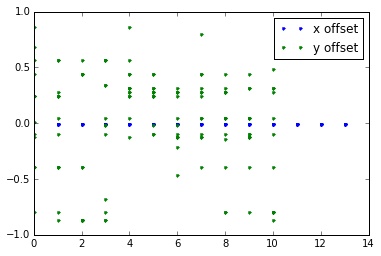

In [71]:
plt.plot(translations[:,3], translations[:,1], '.')
plt.plot(translations[:,2], translations[:,0], '.')
plt.legend(('x offset', 'y offset'));

In [72]:
np.mean(translations[:,1]), np.median(translations[:,1])

(-0.0093055913425819786, -0.0092327390623433998)

In [73]:
np.mean(translations[:,0]), np.median(translations[:,0])

(-0.0048358706747265801, 0.048356717342702381)

# merge rows - fixed offset

In [74]:
height = img1.shape[0]
single_width = img1.shape[1]

In [75]:
# column x
mask = translations[:,3] == 1
translations[mask][:,1], np.mean(translations[mask][:,1])

(array([-0.00938788, -0.00938788, -0.00997305, -0.00934767, -0.00920766,
        -0.00874979, -0.00934767, -0.00920766, -0.00971707, -0.00934767,
        -0.00874979]), -0.0093112534522749382)

In [76]:
x_offsets = []
for col in cols[1:]:
    mask = translations[:,3] == col
    x_offsets.append(translations[mask][:,1].mean())
x_offsets.insert(0, 0) # first image

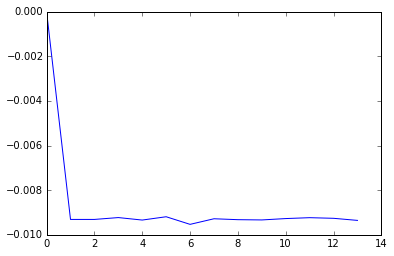

In [77]:
plt.plot(x_offsets);

In [78]:
width = single_width*len(cols) + int(sum(x_offsets))
width

7168

In [79]:
row_imgs = []
for row in rows:
    merged = np.zeros((height, width), dtype=np.uint8)
    for col in cols:
        p = e.image(0,0,col,row)
        offset = x_offsets[col] // 2 # half of each image
        start = single_width*col + int(sum(x_offsets[:col+1]) - offset)
        end = start + single_width + offset
        merged[:,start:end] = io.imread(p)[:,-offset:]
    row_imgs.append(merged)

# merge rows - variable offset

In [272]:
height = img1.shape[0]
single_width = img1.shape[1]

In [273]:
mask = translations[:,2] == 2
translations[mask][:,1], translations[mask][:,1].sum()

(array([-60.5       , -61.        , -57.        , -60.        ,
        -60.5       , -61.        , -58.83113615, -56.        ,
        -59.        , -59.        , -60.        , -60.        ,
        -61.        , -60.        , -58.5       , -56.        , -58.93582888]),
 -1007.266965026166)

In [274]:
row_imgs = []
for row in rows:
    x_offsets = translations[translations[:,2] == row][:,1]
    width = single_width*len(cols) + int(x_offsets.sum())
    merged = np.zeros((height, width), dtype=np.uint8)
    for col in cols:
        p = e.image(0,0,col,row)
        offset = x_offsets[col-1] // 2 # half of each image
        start = single_width*col + int(sum(x_offsets[:col-1]) + offset)
        if col == 0:
            offset = 0
            start = 0
        end = start + single_width + offset
        merged[:,start:end] = io.imread(p)[:,-offset:]
    row_imgs.append(merged)

In [275]:
def same_size(*arrays):
    ys = [arr.shape[0] for arr in arrays]
    xs = [arr.shape[1] for arr in arrays]
    y = max(ys)
    x = max(xs)
    res = []
    for arr in arrays:
        new_arr = np.zeros((y,x), dtype=arr.dtype)
        cy,cx = arr.shape
        new_arr[:cy, :cx] = arr
        res.append(new_arr)
    return res

In [276]:
row_imgs = same_size(*row_imgs)

In [277]:
%time register_translation(row_imgs[0], row_imgs[1], upsample_factor=100)

KeyboardInterrupt: 

In [93]:
%time register_translation(row_imgs[0], row_imgs[1], upsample_factor=10)

CPU times: user 1.49 s, sys: 230 ms, total: 1.72 s
Wall time: 1.67 s


(array([-58.6,  -0.5]), 0.22162371036060383, 7.6502774115025229e-08)

In [92]:
%time register_translation(row_imgs[0], row_imgs[1], upsample_factor=1)

CPU times: user 1.41 s, sys: 231 ms, total: 1.64 s
Wall time: 1.64 s


(array([-59.,  -1.]), 0.22308637129800798, 1.3853430333797005e-19)

# find row translations

In [80]:
prev_img = None
row_translations = []
for img in row_imgs:
    if prev_img != None:
        row_translations.append(register_translation(prev_img, img, upsample_factor=100))
    prev_img = img
row_translations

/Users/arve/.virtualenvs/3.4/lib/python3.4/site-packages/IPython/kernel/__main__.py:4: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


[(array([-132.48,    0.  ]), 0.22598662766677355, -1.3794981958987403e-07),
 (array([ -6.99000000e+01,   1.00000000e-02]),
  0.19575512955760388,
  -1.1599856404589084e-07),
 (array([-73.73,   0.  ]), 0.18177044781780027, -3.0332996119367537e-07),
 (array([  -8.99,  512.01]), 0.18950394570571052, -6.9525715256206233e-08),
 (array([-42.79,   0.  ]), 0.18599340644485785, -6.7272530106814718e-08),
 (array([-35.42,   0.  ]), 0.17693234419745266, 6.1594442316415668e-07),
 (array([-24.44,   0.  ]), 0.16654858007664761, 2.3279305421245611e-07),
 (array([ -4.35700000e+01,  -1.00000000e-02]),
  0.16110465219832318,
  -5.3224518253923183e-07),
 (array([-50.,   0.]), 0.16944604568915433, -1.1377918718327562e-19),
 (array([ -1.93870000e+02,   1.00000000e-02]),
  0.17510888541161626,
  -3.5285236912034613e-07)]

In [81]:
row_offsets = np.array([[t[0][0], t[0][1]] for t in row_translations])

In [82]:
min_x = row_offsets[:,1].min()
row_offsets[:,1] -= min_x # minimum at position zero

In [83]:
row_offsets[:,0], row_offsets[:,1]

(array([-132.48,  -69.9 ,  -73.73,   -8.99,  -42.79,  -35.42,  -24.44,
         -43.57,  -50.  , -193.87]),
 array([  1.00000000e-02,   2.00000000e-02,   1.00000000e-02,
          5.12020000e+02,   1.00000000e-02,   1.00000000e-02,
          1.00000000e-02,   0.00000000e+00,   1.00000000e-02,
          2.00000000e-02]))

In [84]:
cancel_outliers(row_offsets[:,0])

array([-54.8839, -69.9   , -73.73  ,  -8.99  , -42.79  , -35.42  ,
       -24.44  , -43.57  , -50.    , -67.519 ])

In [85]:
# add position of first row
all_row_offsets = np.concatenate(([[0,-min_x]], row_offsets))

In [86]:
all_row_offsets

array([[  0.00000000e+00,   1.00000000e-02],
       [ -5.48839000e+01,   1.00000000e-02],
       [ -6.99000000e+01,   2.00000000e-02],
       [ -7.37300000e+01,   1.00000000e-02],
       [ -8.99000000e+00,   5.12020000e+02],
       [ -4.27900000e+01,   1.00000000e-02],
       [ -3.54200000e+01,   1.00000000e-02],
       [ -2.44400000e+01,   1.00000000e-02],
       [ -4.35700000e+01,   0.00000000e+00],
       [ -5.00000000e+01,   1.00000000e-02],
       [ -6.75190000e+01,   2.00000000e-02]])

# merge row with variable offset

In [87]:
# use calculated offsets
y_offsets = all_row_offsets[:,0]
x_offsets = all_row_offsets[:,1]
single_height = row_imgs[0].shape[0]
width = row_imgs[0].shape[1]
height = len(rows)*single_height + int(sum(y_offsets))
height, width

(5161, 7168)

In [88]:
merged = np.zeros((height, width), dtype=np.uint8)
for row,img in enumerate(row_imgs):
    x_start = int(x_offsets[row])
    # roll destination array (as row_imgs are padded with zeros)
    merged = np.roll(merged, -x_start, axis=1)
    offset = y_offsets[row] // 2
    start = single_height*row + int(sum(y_offsets[:row+1]) - offset)
    end = start + single_height + offset
    merged[start:end,:] = img[-offset:,:]
    # roll back
    merged = np.roll(merged, x_start, axis=1)

In [179]:
%matplotlib qt

In [180]:
io.imshow(merged, interpolation='none')

In [89]:
io.imsave('stitched-registration-equalized.png', merged)